In [1]:
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit import Chem
%matplotlib inline
from rdkit.Chem import Draw
from IPython.core.display import display, HTML
from rdkit.Chem import AllChem
import os, sys
from openeye import oechem
import openmoltools as omtff
from openmoltools import forcefield_generators
import lxml
from io import StringIO
from lxml import etree
from simtk import unit
import pickle
import parmed as pm
import simtk.openmm as mm
import simtk.openmm.app as app
from simtk.openmm.app import StateDataReporter
import csv
import nglview
import mdtraj as md
import numpy as np
import matplotlib.pylab as plt


gaff_default = os.path.join("../data/gaff2.xml")




In [2]:
#name = 'molDWRow_590'
#name = 'molDWRow_298'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_37'


In [3]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

In [4]:
def run_dynamics_with_openMM(sim, dcd_output_filepath, traj_name, nr_of_steps):
    # Set up the reporters to report energies and coordinates every 100 steps

    print('Writing trajectory to: ', dcd_output_filepath)
    print('as: ', traj_name)
    sim.reporters.append(
        StateDataReporter(sys.stderr, 50000, step=True, potentialEnergy=True,
                          kineticEnergy=True, temperature=True,
                          volume=True, density=True)
        )
    sim.reporters.append(app.DCDReporter(dcd_output_filepath + '/' + traj_name, 100))

    # Run dynamics
    print('Running dynamics')
    sim.step(int(nr_of_steps))




In [5]:
# write out confs that are in save_confs list
# and start vacuum md
def create_hydrogen_definitions(
    xmltree
):
    """
    Generates hydrogen definitions for a small molecule residue template.

    """
    hydrogen_definitions_tree = etree.fromstring("<Residues/>")
    for residue in xmltree.xpath("Residues/Residue"):
        hydrogen_file_residue = etree.fromstring("<Residue/>")
        hydrogen_file_residue.set("name", residue.get("name"))
        # enumerate hydrogens in this list
        hydrogens = list()
        # Loop through atoms to find all hydrogens
        for bond in residue.xpath("Bond"):
            atomname1 = bond.get("atomName1")
            atomname2 = bond.get("atomName2")
            if 'H' in atomname1:
                # H is the first, parent is the second atom
                hydrogens.append(tuple([atomname1, atomname2]))
            elif 'H' in atomname2:
                # H is the second, parent is the first atom
                hydrogens.append(tuple([atomname2, atomname1]))

        # Loop through all hydrogens, and create definitions
        for name, parent in hydrogens:
            h_xml = etree.fromstring("<H/>")
            h_xml.set("name", name)
            h_xml.set("parent", parent)
            hydrogen_file_residue.append(h_xml)
        hydrogen_definitions_tree.append(hydrogen_file_residue)
    # Write output
    return hydrogen_definitions_tree



def create_bond_definitions(
    inputfile: str,
    residue_name : str = None
    ):
    """
    Generates bond definitions for a small molecule template to subsequently load 
    the bond definitions in the topology object. BE CAREFULL: The residue name 
    of the pdb file must match the residue name in the bxml file.

    Parameters
    ----------
    inputfile - a forcefield XML file defined using Gaff atom types
    """

    xmltree = etree.parse(
        inputfile, etree.XMLParser(remove_blank_text=True, remove_comments=True)
    )
    # Output tree
    bond_definitions_tree = etree.fromstring("<Residues/>")
    bonds = set()

    for residue in xmltree.xpath("Residues/Residue"):
        # Loop through all bonds
        bond_file_residue = etree.fromstring("<Residue/>")
        bond_file_residue.set("name", f"{residue_name}")
        for bond in residue.xpath("Bond"):
            atomname1 = bond.get("atomName1")
            atomname2 = bond.get("atomName2")
            if atomname1.startswith('H') or atomname2.startswith('H'):
                continue
            bonds.add(tuple([atomname1, atomname2]))
        
        for a1, a2 in bonds:
            b_xml = etree.fromstring("<Bond/>")
            b_xml.set("from", a1)
            b_xml.set("to", a2)
            bond_file_residue.append(b_xml)
        bond_definitions_tree.append(bond_file_residue)

    return bond_definitions_tree


In [6]:
# run MD and plot properties to compare to
   
if not os.path.exists(f"../data/md_sampling/{name}"):
    os.mkdir(f"../data/md_sampling/{name}")

ofs = oechem.oemolostream()
for t_id, t in enumerate([exp_results[name]['t1-smiles'], exp_results[name]['t2-smiles']]):
    t_id = t_id + 1
    m = omtff.openeye.smiles_to_oemol(t)
    m = omtff.openeye.generate_conformers(m, max_confs=1)
    m.SetTitle(f"t{t_id:02d}")

    ffxml = forcefield_generators.generateForceFieldFromMolecules(
        [m], normalize=False, gaff_version='gaff2'
    )


    # write mol2
    ofs.open(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}.mol2")
    ofs.SetFormat(oechem.OEFormat_MOL2)
    oechem.OEWriteMolecule(ofs, m)

    # write pdb
    ofs.open(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}.pdb")
    ofs.SetFormat(oechem.OEFormat_PDB)
    oechem.OEWriteMolecule(ofs, m)


    # create bond and hydrogen definitions
    bxml = create_bond_definitions(StringIO(ffxml), f"t{t_id:02d}")
    bxml = StringIO(etree.tostring(bxml).decode("utf-8"))

    app.Topology.loadBondDefinitions(bxml)

    hxml = create_hydrogen_definitions(etree.fromstring(ffxml))
    hxml = StringIO(etree.tostring(hxml).decode("utf-8"))
    app.Modeller.loadHydrogenDefinitions(hxml)

    forcefield = app.ForceField("amber10.xml", gaff_default, StringIO(ffxml), "tip3p.xml")

    pdb = app.PDBFile(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}.pdb")
    modeller = app.Modeller(pdb.topology, pdb.positions)
    modeller.addHydrogens()

    integrator = mm.LangevinIntegrator(
                    300*unit.kelvin,       # Temperature of heat bath
                    1.0/unit.picoseconds,  # Friction coefficient
                    2.0*unit.femtoseconds, # Time step
)


    system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)




    sim = app.Simulation(modeller.topology, system, integrator)
    sim.context.setPositions(modeller.positions)

    sim.minimizeEnergy(maxIterations=5000)
    sim.reporters.append(
            StateDataReporter(sys.stdout, 10000, step=True, potentialEnergy=True,
                              kineticEnergy=True, temperature=True,
                              volume=True, density=True)
    )
    sim.reporters.append(StateDataReporter(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}_gaff_energy.csv", 10, time=True,
    kineticEnergy=True, potentialEnergy=True))

    sim.reporters.append(app.DCDReporter(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}_gaff.dcd", 10))
    sim.step(500000)


/home/mwieder/anaconda3/envs/torchANI-dev/lib/python3.6/site-packages/parmed/openmm/parameters.py:127: UserWarning: Residue t01 contains atom type oh not found in parameter set and will be dropped.
  warnings.warn('Residue {} contains atom type {} not found in parameter set and will be dropped.'.format(residue.name, atom.type))


#"Step","Potential Energy (kJ/mole)","Kinetic Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Density (g/mL)"
10000,-171.45900752907096,42.33448127047313,231.4391694559208,8.0,0.030129645936086673
20000,-168.85241645415914,43.698839143838214,238.89800309639577,8.0,0.030129645936086673
30000,-167.60630155896297,67.35255870241171,368.2109660734035,8.0,0.030129645936086673
40000,-153.05770742691104,35.798308896301755,195.70644614618627,8.0,0.030129645936086673
50000,-165.49422661924683,58.5890020692434,320.30131399329116,8.0,0.030129645936086673
60000,-182.52924209242897,34.970478790264636,191.18076621715244,8.0,0.030129645936086673
70000,-175.51001275322304,60.28859681867862,329.59286039745797,8.0,0.030129645936086673
80000,-158.88707051214993,55.848353963173615,305.31841347332823,8.0,0.030129645936086673
90000,-180.43552479745233,62.17723303781098,339.9178811569595,8.0,0.030129645936086673
100000,-162.5670298069043,60.56948187796522,331.1284361948449,8.0,0.030129645936086673
11

/home/mwieder/anaconda3/envs/torchANI-dev/lib/python3.6/site-packages/parmed/openmm/parameters.py:127: UserWarning: Residue t02 contains atom type o not found in parameter set and will be dropped.
  warnings.warn('Residue {} contains atom type {} not found in parameter set and will be dropped.'.format(residue.name, atom.type))


#"Step","Potential Energy (kJ/mole)","Kinetic Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Density (g/mL)"
10000,-107.11525105677043,56.473918417462535,308.73832351821056,8.0,0.030129645936086673
20000,-126.8131368469333,69.98610888718358,382.60837095926894,8.0,0.030129645936086673
30000,-115.4583705073262,48.3315563059183,264.22469141615613,8.0,0.030129645936086673
40000,-116.75068864618794,49.982534128408766,273.25045303081043,8.0,0.030129645936086673
50000,-126.66504580103243,52.70355958991297,288.1260781472608,8.0,0.030129645936086673
60000,-117.79075374035823,51.171231343099144,279.7489641226279,8.0,0.030129645936086673
70000,-111.89615810602965,55.89933726636398,305.59713504950895,8.0,0.030129645936086673
80000,-114.54696372490496,41.13722896691085,224.8938883883362,8.0,0.030129645936086673
90000,-124.33059578656179,52.26373958820591,285.7216179330245,8.0,0.030129645936086673
100000,-111.05748940095842,57.236776623017015,312.9088073462315,8.0,0.030129645936086673
1100

molDWRow_590


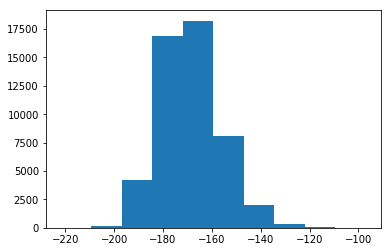

molDWRow_590


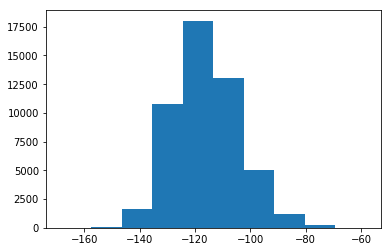

In [4]:
for t_id in [1, 2]:
    print(name)
    pot_energy = []
    with open(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}_gaff_energy.csv", newline='') as csvfile:
        report = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in report:
            if str(row[0]).startswith('#'):
                continue
            pot_energy.append(float(row[1]))
    plt.hist(np.array(pot_energy))#, np.linspace(0, 500) )
    plt.show()

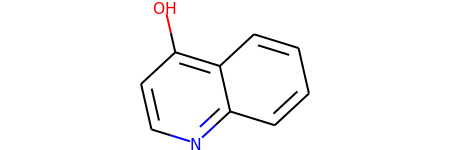

Mean: 30.615516992260094
Mean: 118.62623373116122
Mean: 122.70669802435356


/home/mwieder/anaconda3/envs/torchANI-dev/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


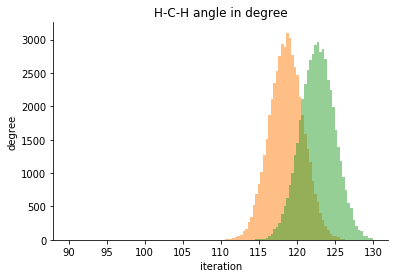

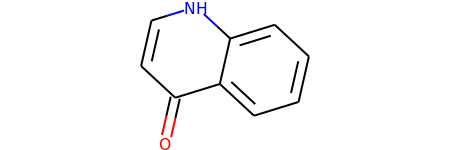

Mean: 30.077690821540365
Mean: 121.30517052742361
Mean: 119.71310807340701


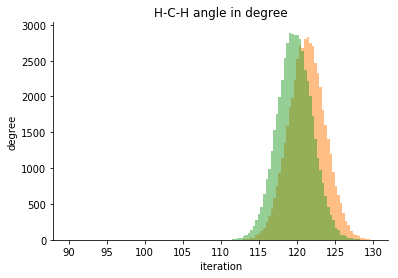

In [5]:
# plot angles


for t_id in [1, 2]:   
    m = Chem.MolFromMol2File(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}.mol2")
    
    AllChem.Compute2DCoords(m)
    display(m)
    
    traj = md.load(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}_gaff.dcd", top=f"../data/md_sampling/{name}/{name}_tautomer_{t_id}.pdb")


    l = md.compute_angles(traj, np.array([[4, 3, 5]], np.int32))
    plt.hist(l[1::] * 180/np.pi,linewidth=0.5, bins=np.linspace(90, 130, 120), alpha=0.5, label='t{}'.format(t_id))
    print('Mean: {}'.format(np.mean(l)* 180/np.pi))
    
    l = md.compute_angles(traj, np.array([[1, 2, 3]], np.int32))
    plt.hist(l[1::] * 180/np.pi,linewidth=0.5, bins=np.linspace(90, 130, 120), alpha=0.5, label='t{}'.format(t_id))
    print('Mean: {}'.format(np.mean(l)* 180/np.pi))

    l = md.compute_angles(traj, np.array([[2, 3, 4]], np.int32))
    plt.hist(l[1::] * 180/np.pi,linewidth=0.5, bins=np.linspace(90, 130, 120), alpha=0.5, label='t{}'.format(t_id))
    print('Mean: {}'.format(np.mean(l)* 180/np.pi))

    
    ax = plt.subplot(1,1,1)

    plt.xlabel('iteration')
    plt.ylabel('degree')
    plt.title('H-C-H angle in degree')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #plt.savefig('test_angles_vs_iterations_ni1ccx_2_0.png', dpi=300, bbox_inches='tight')
    plt.show()
    

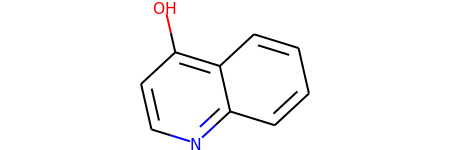

Mean: -0.19361259763800112
Mean: -0.0007055554876041342
Mean: 0.0017679357280314546
Mean: -0.0009629394250040204


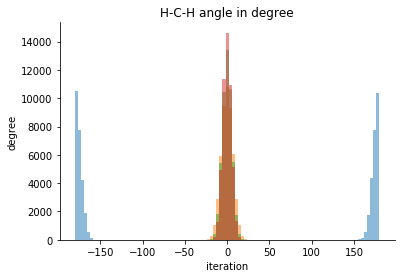

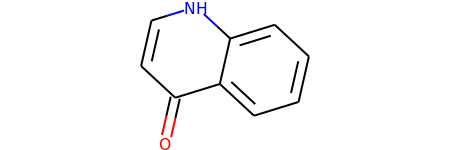

Mean: 0.021568596810669728
Mean: 0.6306663707867736
Mean: -0.2901434744148062
Mean: 0.4219346424928468


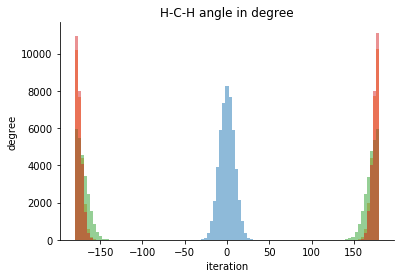

In [6]:
# plot dihedrals

traj_list = []
for t_id in [1, 2]:
    m = Chem.MolFromMol2File(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}.mol2")
    
    AllChem.Compute2DCoords(m)
    display(m)
    
    traj = md.load(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}_gaff.dcd", top=f"../data/md_sampling//{name}/{name}_tautomer_{t_id}.pdb")
    traj_list.append(traj)
    l = md.compute_dihedrals(traj, np.array([[0, 1, 2, 3]], np.int32))
    plt.hist(l[1::] * 180/np.pi,linewidth=0.5, bins=np.linspace(-180, 180, 100), alpha=0.5, label='t{}'.format(t_id))
    print('Mean: {}'.format(np.mean(l)* 180/np.pi))

    l = md.compute_dihedrals(traj, np.array([[1, 2, 3, 4]], np.int32))
    plt.hist(l[1::] * 180/np.pi,linewidth=0.5, bins=np.linspace(-180, 180, 100), alpha=0.5, label='t{}'.format(t_id))
    print('Mean: {}'.format(np.mean(l)* 180/np.pi))

    l = md.compute_dihedrals(traj, np.array([[6, 1, 2, 3]], np.int32))
    plt.hist(l[1::] * 180/np.pi,linewidth=0.5, bins=np.linspace(-180, 180, 100), alpha=0.5, label='t{}'.format(t_id))
    print('Mean: {}'.format(np.mean(l)* 180/np.pi))

    l = md.compute_dihedrals(traj, np.array([[1, 2, 3, 5]], np.int32))
    plt.hist(l[1::] * 180/np.pi,linewidth=0.5, bins=np.linspace(-180, 180, 100), alpha=0.5, label='t{}'.format(t_id))
    print('Mean: {}'.format(np.mean(l)* 180/np.pi))

    
    ax = plt.subplot(1,1,1)

    plt.xlabel('iteration')
    plt.ylabel('degree')
    plt.title('H-C-H angle in degree')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#plt.savefig('test_angles_vs_iterations_ni1ccx_2_0.png', dpi=300, bbox_inches='tight')
    plt.show()
    

In [7]:
nglview.show_mdtraj(traj_list[0])

NGLWidget(count=50000)

In [8]:
nglview.show_mdtraj(traj_list[1])

NGLWidget(count=50000)

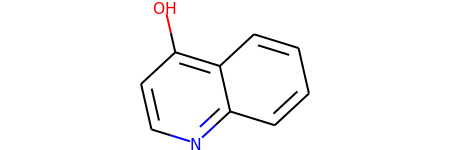

Mean: -0.19361259763800112
Mean: -0.0007055554876041342
Mean: 0.0017679357280314546
Mean: -0.0009629394250040204


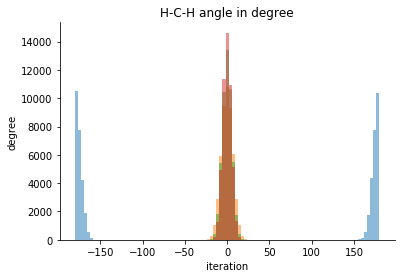

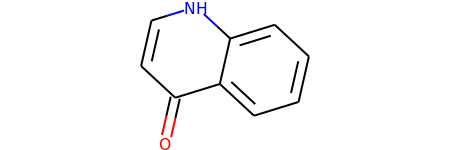

Mean: 0.021568596810669728
Mean: 0.6306663707867736
Mean: -0.2901434744148062
Mean: 0.4219346424928468


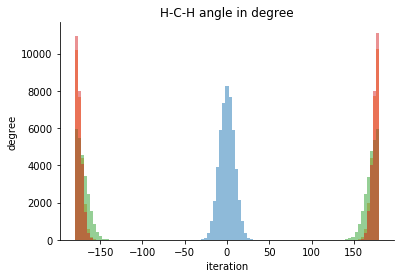

In [9]:
# plot dihedrals

for t_id in [1, 2]:
    m = Chem.MolFromMol2File(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}.mol2")
    
    AllChem.Compute2DCoords(m)
    display(m)
    
    traj = md.load(f"../data/md_sampling/{name}/{name}_tautomer_{t_id}_gaff.dcd", top=f"../data/md_sampling//{name}/{name}_tautomer_{t_id}.pdb")


    l = md.compute_dihedrals(traj, np.array([[0, 1, 2, 3]], np.int32))
    plt.hist(l[1::] * 180/np.pi,linewidth=0.5, bins=np.linspace(-180, 180, 100), alpha=0.5, label='t{}'.format(t_id))
    print('Mean: {}'.format(np.mean(l)* 180/np.pi))

    l = md.compute_dihedrals(traj, np.array([[1, 2, 3, 4]], np.int32))
    plt.hist(l[1::] * 180/np.pi,linewidth=0.5, bins=np.linspace(-180, 180, 100), alpha=0.5, label='t{}'.format(t_id))
    print('Mean: {}'.format(np.mean(l)* 180/np.pi))

    l = md.compute_dihedrals(traj, np.array([[6, 1, 2, 3]], np.int32))
    plt.hist(l[1::] * 180/np.pi,linewidth=0.5, bins=np.linspace(-180, 180, 100), alpha=0.5, label='t{}'.format(t_id))
    print('Mean: {}'.format(np.mean(l)* 180/np.pi))

    l = md.compute_dihedrals(traj, np.array([[1, 2, 3, 5]], np.int32))
    plt.hist(l[1::] * 180/np.pi,linewidth=0.5, bins=np.linspace(-180, 180, 100), alpha=0.5, label='t{}'.format(t_id))
    print('Mean: {}'.format(np.mean(l)* 180/np.pi))

    
    ax = plt.subplot(1,1,1)

    plt.xlabel('iteration')
    plt.ylabel('degree')
    plt.title('H-C-H angle in degree')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #plt.savefig('test_angles_vs_iterations_ni1ccx_2_0.png', dpi=300, bbox_inches='tight')
    plt.show()
    